# Our primary task is to develop a classification model or generative AI application to distinguish between legitimate (non-spam) and spam messages.

## I propose three approaches to develop our spam detection model.
   1. Traditional machine learning classification models
       *   Logistic Regression
       *   Random Forest
       *   XGBoost
       *   Stacked Classifier

   2. Deep Learning technique
       *   RNNs : LSTM model
    
   3. Large Language Models
       *   RoBERTa : BERT-like LLM
       *   MistralAI : GenAI LLM 7B parameters

## In this notebook, I will explore the first approach. Models are simple and hence I won't be using NVIDIA GPUs. Runtime type is set to T4 GPUs.

        





                               

## Dataset Overview:

I am provided with two datasets: human.txt and spam.txt (attached to this email). The human.txt file contains SMS text messages submitted by humans, while spam.txt includes messages flagged as spam. Each line in these files represents a unique data point.

## Data Preprocessing and Exploratory Data Analysis (EDA)

I have two seperate text files for spam and ham messages. I will read these text files and convert them to a CSV file. I will add one more column named "flag" which will tell if message is spam.



In [ ]:
import csv

# Give input_file the path to the human.txt file
input_file = 'human.txt'
output_file = 'HAM.csv'

# Read lines from the text file
with open(input_file, 'r') as file:
    lines = file.readlines()

# Write lines into a CSV file with 'message' and 'flag' as columns
with open(output_file, 'w', newline='') as csv_file:
    fieldnames = ['message', 'flag']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    for line in lines:
        writer.writerow({'message': line.strip(), 'flag': 0})

In [ ]:
import csv

# Give input_file the path to your spam.txt file
input_file = 'spam.txt'
output_file = 'SPAM.csv'

# Read lines from the text file
with open(input_file, 'r') as file:
    lines = file.readlines()

# Write lines into a CSV file with 'message' and 'flag' as columns
with open(output_file, 'w', newline='') as csv_file:
    fieldnames = ['message', 'flag']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()

    for line in lines:
        writer.writerow({'message': line.strip(), 'flag': 1})

In [ ]:
#Load created CSV files to pandas dataframe
import pandas as pd

ham=pd.read_csv("HAM.csv")
spam=pd.read_csv("SPAM.csv")

In [ ]:
#Merge spam and ham dataframes
ham_and_spam = pd.concat([ham, spam])

In [ ]:
#Create one single CSV file to store all ham and spam messages
ham_and_spam.to_csv("ham_and_spam.csv")

In [ ]:
#Import required libraries for our code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [ ]:
#Install libraries in our current environment using pip
!pip install scikit-plot
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [ ]:
#Check how many datapoints we have
print(ham_and_spam.shape)

(5092, 2)


In [ ]:
#Check the distribution of ham and spam messages in our dataframe
# We can see that we have imbalanced dataset
ham_and_spam['flag'].value_counts()

0    4603
1     489
Name: flag, dtype: int64

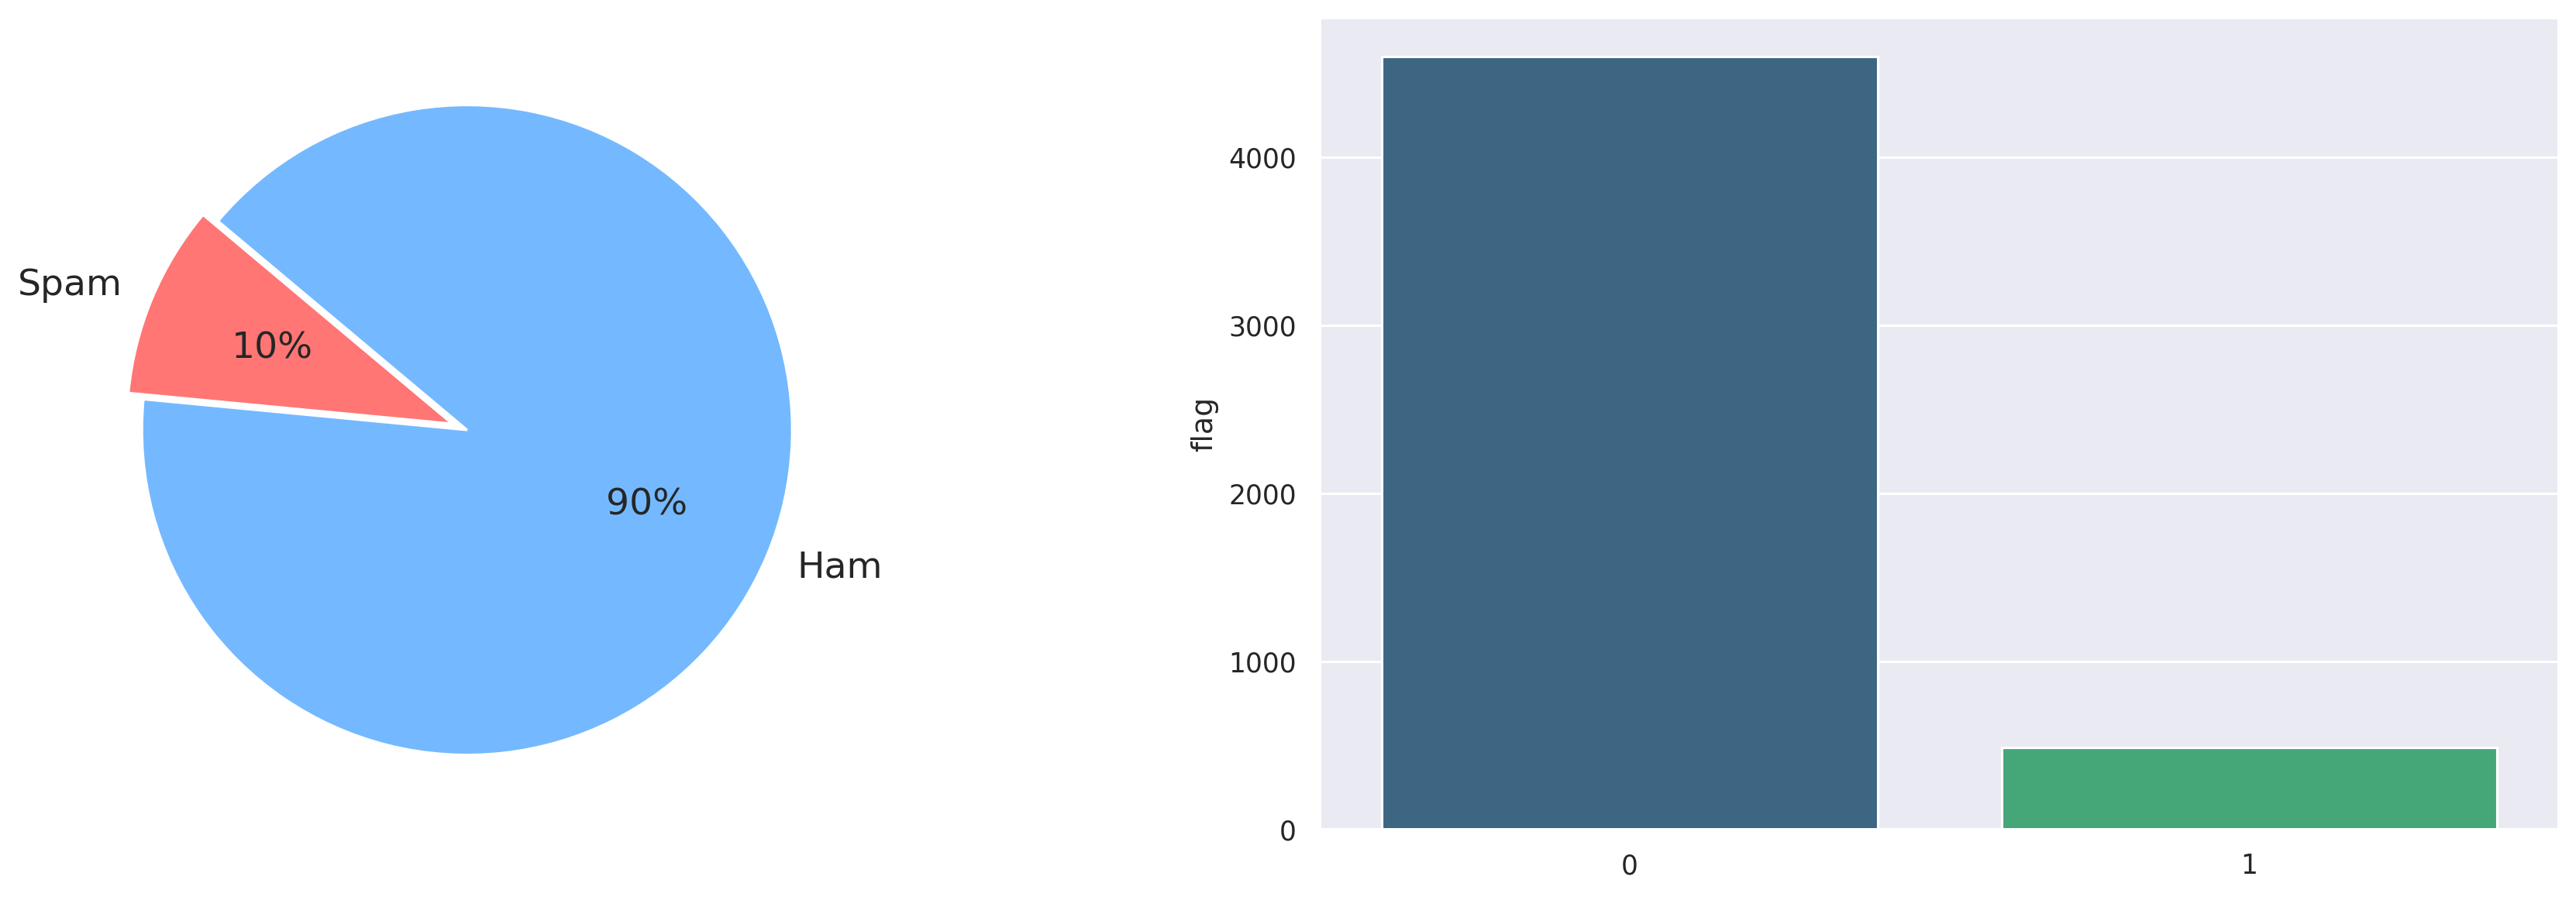

In [ ]:
#Create pie chart and bar plot to show the distribution of our dataset
labels = ['Spam', 'Ham']
sizes = [489, 4603]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140,
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 2)
sns.barplot(x = ham_and_spam['flag'].unique(), y = ham_and_spam['flag'].value_counts(), palette= 'viridis')

plt.show()

### Only 10% of messages are spam. Hence, our dataset is imbalanced. Even if our model predicts the message as ham each time, it will achieve 90% accuracy. To overcome this problem, we can either make dataset balanced using techniques like SMOTE or use ensemble models which handle data imbalance well. We don't want to add any synthetic data, hence we won't be making our dataset balanced.

In [ ]:
# Add one more column which will store total no. of words in the message
ham_and_spam['Total Words'] = ham_and_spam['message'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

# Add one more column which will store total no. of characters in the message
ham_and_spam['Total Chars'] = ham_and_spam["message"].apply(count_total_words)

In [ ]:
#Let's see how our dataset looks like now
ham_and_spam.head()

,message,flag,Total Words,Total Chars
0,"""Go until jurong point, crazy.. Available only...",0,20,94
1,Ok lar... Joking wif u oni...,0,6,24
2,U dun say so early hor... U c already then say...,0,11,39
3,"""Nah I don't think he goes to usf, he lives ar...",0,13,51
4,Even my brother is not like to speak with me. ...,0,16,62


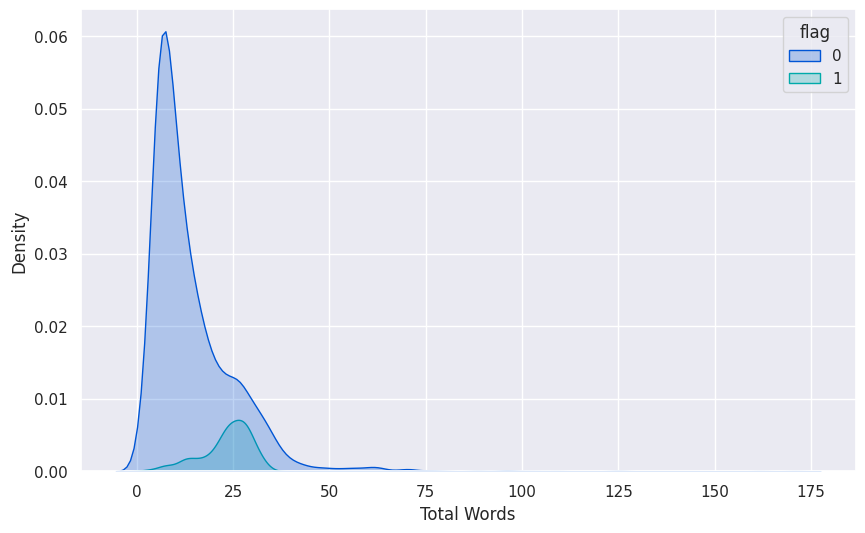

In [ ]:
#We have created 2 new features in our dataset, lets try to see how our target variable changes based on these features
plt.figure(figsize = (10, 6))
sns.kdeplot(x = ham_and_spam['Total Words'], hue= ham_and_spam['flag'], palette= 'winter', shade = True)
plt.show()

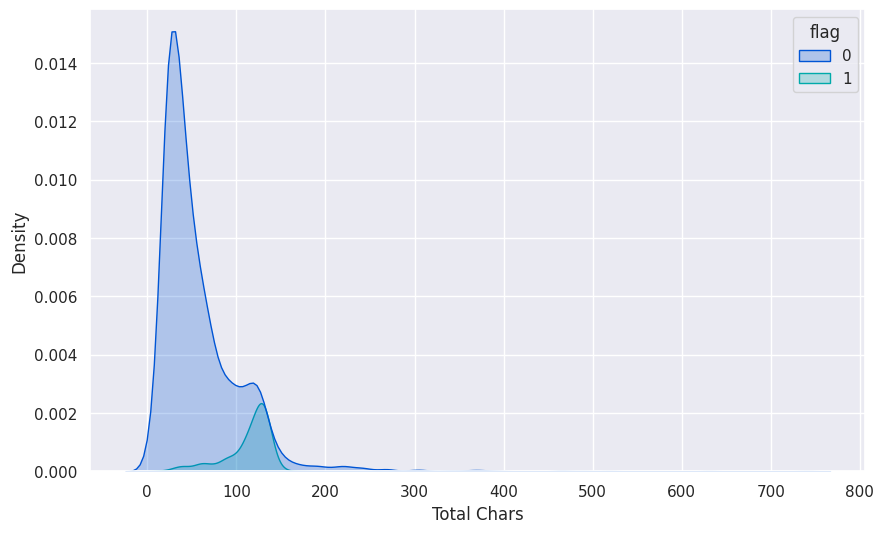

In [ ]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = ham_and_spam['Total Chars'], hue= ham_and_spam['flag'], palette= 'winter', shade = True)
plt.show()

####Clearly, one thing we can conclude here is that more the number of words in a text, there are more chances of it being spam

####The texts we recieve have multiple factors that are unwanted and unhelpful. providing that data to the machine learning algorthim will make it just suffer. Instead lets take on some approach to clean up the text as much as possible.

In [ ]:
#Convert all the characters of message to lowercase
def convert_lowercase(text):
    text = text.lower()
    return text

ham_and_spam['message'] = ham_and_spam['message'].apply(convert_lowercase)

In [ ]:
#we need to take a look into the text message to find if there are any unwanted url links.
#This information is generally not useful- so we shall be removing them i the first step\
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

ham_and_spam['message'] = ham_and_spam['message'].apply(remove_url)

In [ ]:
#For a text classifier- we genrally tend to remove all the punctuatuions, as they are of no use in a text predictor
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

ham_and_spam['message'] = ham_and_spam['message'].apply(remove_punc)

In [ ]:
#Remove stopwords from the messages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

ham_and_spam['message'] = ham_and_spam['message'].apply(remove_stopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Finally, we will need to stemmatize the words.
# Stemming is the process of grouping together the different inflected forms of a word so they can be analysed as a single item.
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

ham_and_spam['message'] = ham_and_spam['message'].apply(perform_stemming)

In [ ]:
#Calculate the total words after we have pre-processed our text
ham_and_spam['Total Words After Transformation'] = ham_and_spam['message'].apply(lambda x: np.log(len(x.split())))

In [ ]:
ham_and_spam.head()

,message,flag,Total Words,Total Chars,Total Words After Transformation
0,go jurong point crazi avail bugi n great world...,0,20,94,2.772589
1,ok lar joke wif u oni,0,6,24,1.791759
2,u dun say earli hor u c alreadi say,0,11,39,2.197225
3,nah dont think goe usf live around though,0,13,51,2.079442
4,even brother like speak treat like aid patent,0,16,62,2.079442


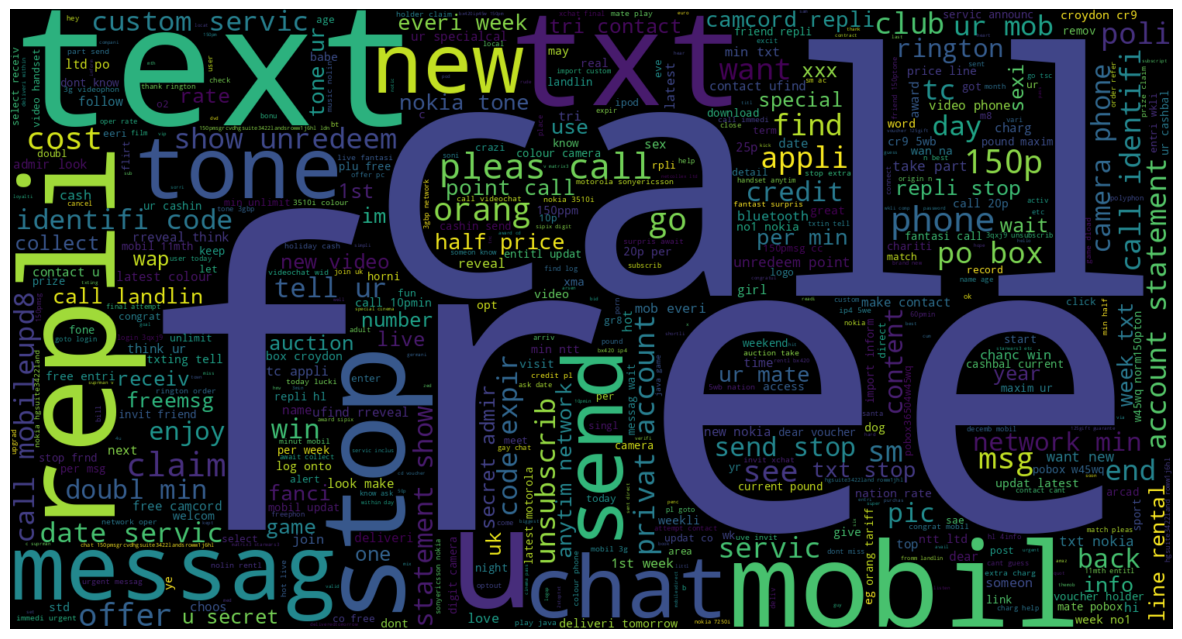

In [ ]:
#Plot wordcloud for Spam messages
text = " ".join(ham_and_spam[ham_and_spam['flag'] == 1]['message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### We can see that spam messages contain words such as free ,call, and repli. This is as per our expectation.

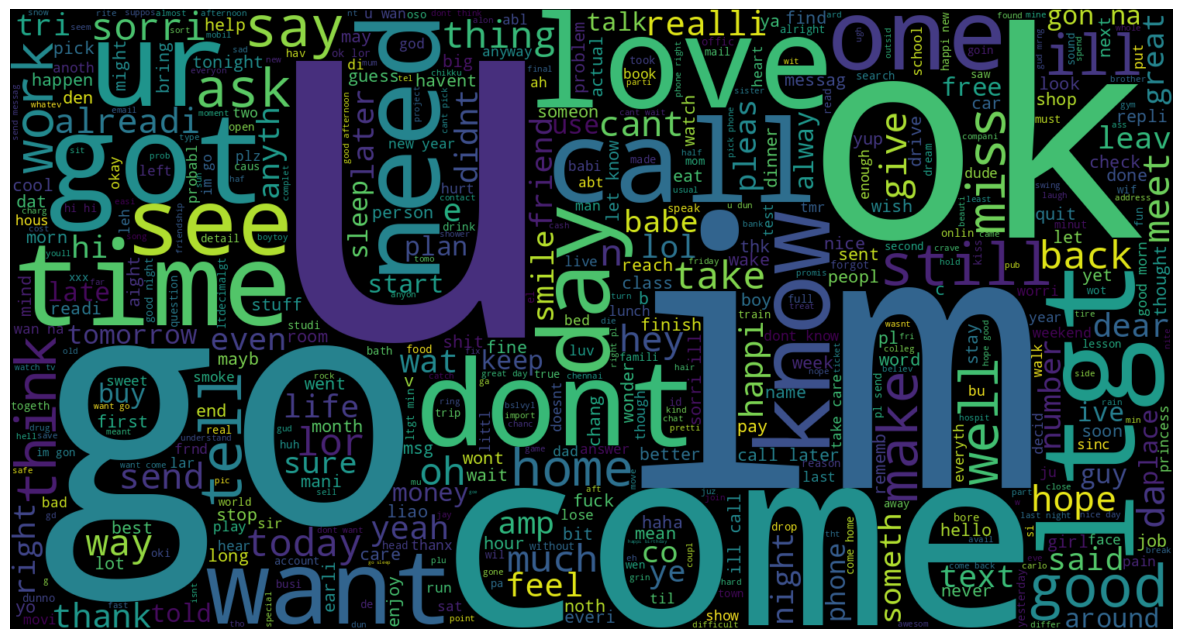

In [ ]:
#Plot wordcloud for ham messages
text = " ".join(ham_and_spam[ham_and_spam['flag'] == 0]['message'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Wordcloud of ham messages contain normal words that we use in day to day life conversation.

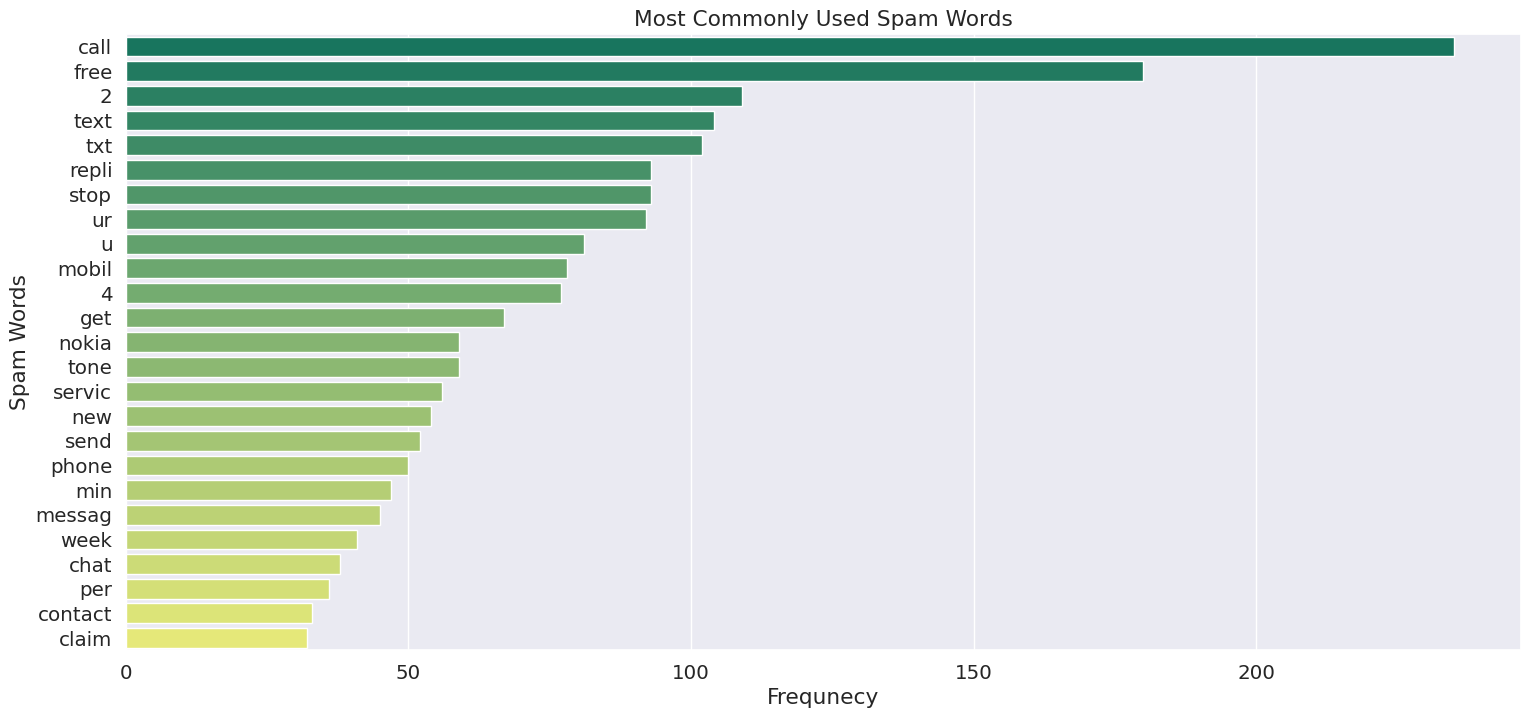

In [ ]:
#Bar plot for top commonly used spam words.
all_spam_words = []
for sentence in ham_and_spam[ham_and_spam['flag'] == 1]['message'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Spam Words")
plt.show()

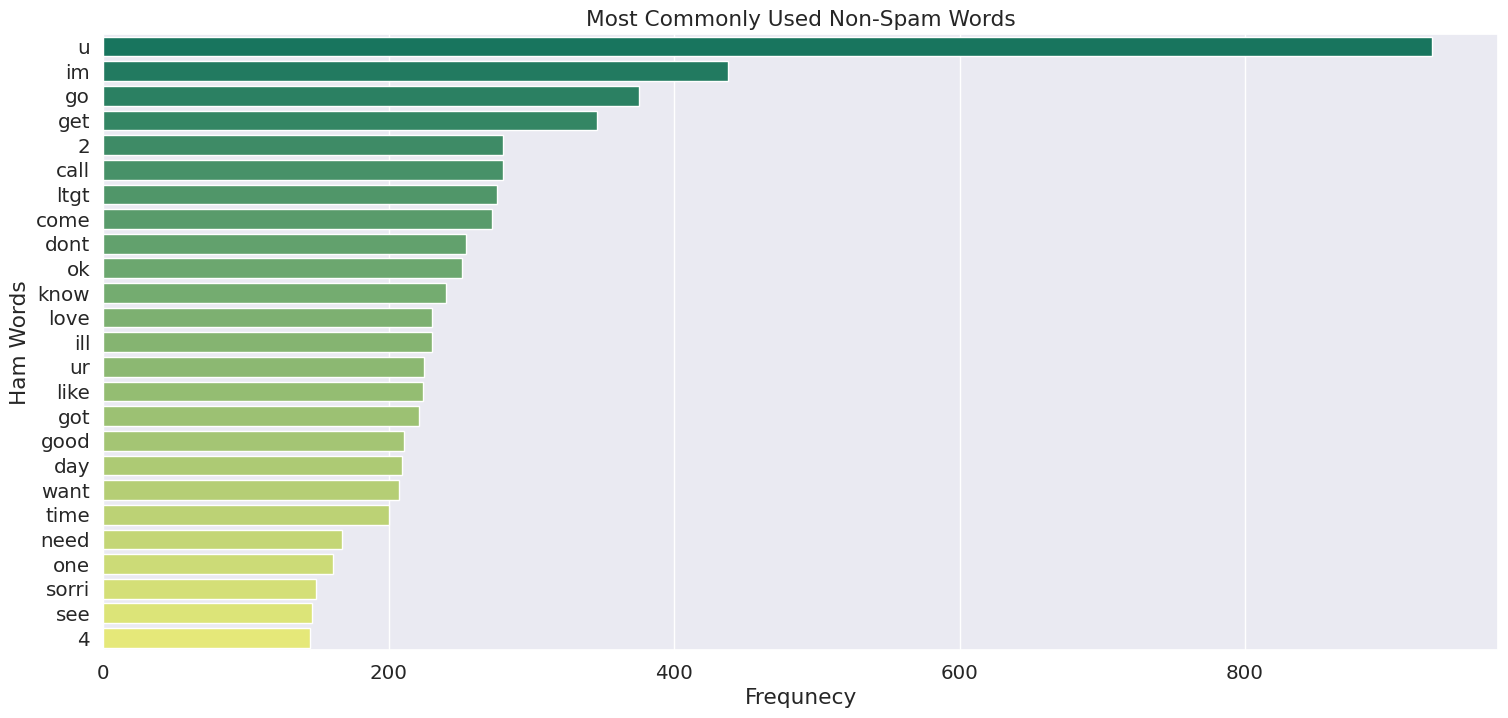

In [ ]:
#Bar plot for top commonly used ham words.
all_ham_words = []
for sentence in ham_and_spam[ham_and_spam['flag'] == 0]['message'].to_list():
    for word in sentence.split():
        all_ham_words.append(word)

df = pd.DataFrame(Counter(all_ham_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Non-Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Ham Words")
plt.show()

#### It can be seen that words common in spam messages are not commonly observed in ham messages. The percentage of occurrence of spam words are very high too in spam messages.

## Model development and evaluation

In [ ]:
#Now let's create training and testing datasets manually.
#X = ham_and_spam["message"]
#y = ham_and_spam['flag'].values

import pandas as pd
# Split the dataset based on labels
label_0_data = ham_and_spam[ham_and_spam['flag'] == 0]
label_1_data = ham_and_spam[ham_and_spam['flag'] == 1]

# Randomly sample 400 ham points and 200 spam points from each group
sampled_label_0 = label_0_data.sample(n=400, replace=False, random_state=42)
sampled_label_1 = label_1_data.sample(n=200, replace=False, random_state=42)

# Concatenate the sampled data to create the new balanced test dataset
test_dataset = pd.concat([sampled_label_0, sampled_label_1])

#Create training dataset by removing test_dataset from our original dataset
train_dataset = ham_and_spam.merge(test_dataset, indicator=True, how='outer').loc[lambda x: x['_merge'] == 'left_only']

#Create X and Y lables for our datasets
X_train=train_dataset["message"]
y_train=train_dataset["flag"].values
X_test=test_dataset["message"]
y_test=test_dataset["flag"].values

In [ ]:
#Tfidf Vectorizer is used to encode the documents into vectors as input into the models for training and test.
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [ ]:
#Define the function to train our models and then calculate the valuation metrics.
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)
    f1score=round(f1_score(y_test,y_pred),3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')
    print(f'F1 Score of the model: {f1score}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

### Logistic Regression

Accuracy of the model: 0.917
Precision Score of the model: 1.0
Recall Score of the model: 0.75
F1 Score of the model: 0.857


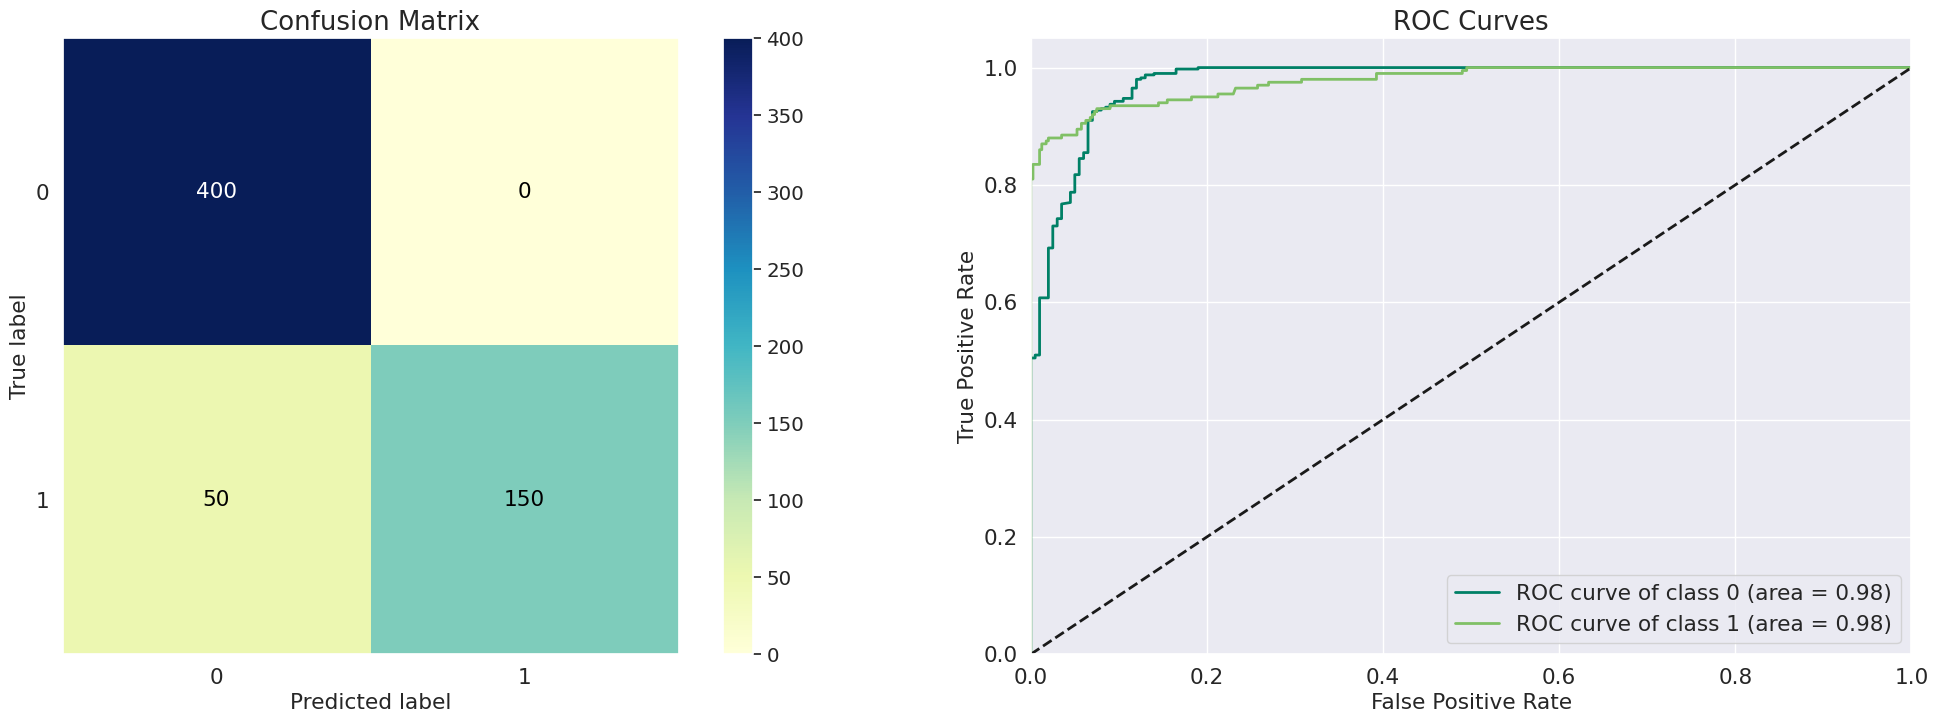

In [ ]:
#Load logistic regression model from sklearn
# We will use GridSearchCV for finding the ideal set of hyper parameters for our hypertuning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1.0, 10.0],  # Regularization parameter
    'penalty': ['l1', 'l2']  # Penalty norm
}
logistic_regression = LogisticRegression()
# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


#Call the train fucntion to train the model and calculate the evaluation metrics
# Train fucntion will also plot the confusion matric and AUC/ROC curves
# Evaluate the model on the test set using the best parameters

train_model(best_model)

#### Our test dataset contains 600 datapoints. 400 are hams and 200 are spams. Logistic regression model classifies ham messages without any error.In case of spam messages, it identified 150 spam messages correctly while it identified 50 spam messages incorrectly as ham.

### Random Forest

Accuracy of the model: 0.892
Precision Score of the model: 1.0
Recall Score of the model: 0.675
F1 Score of the model: 0.806


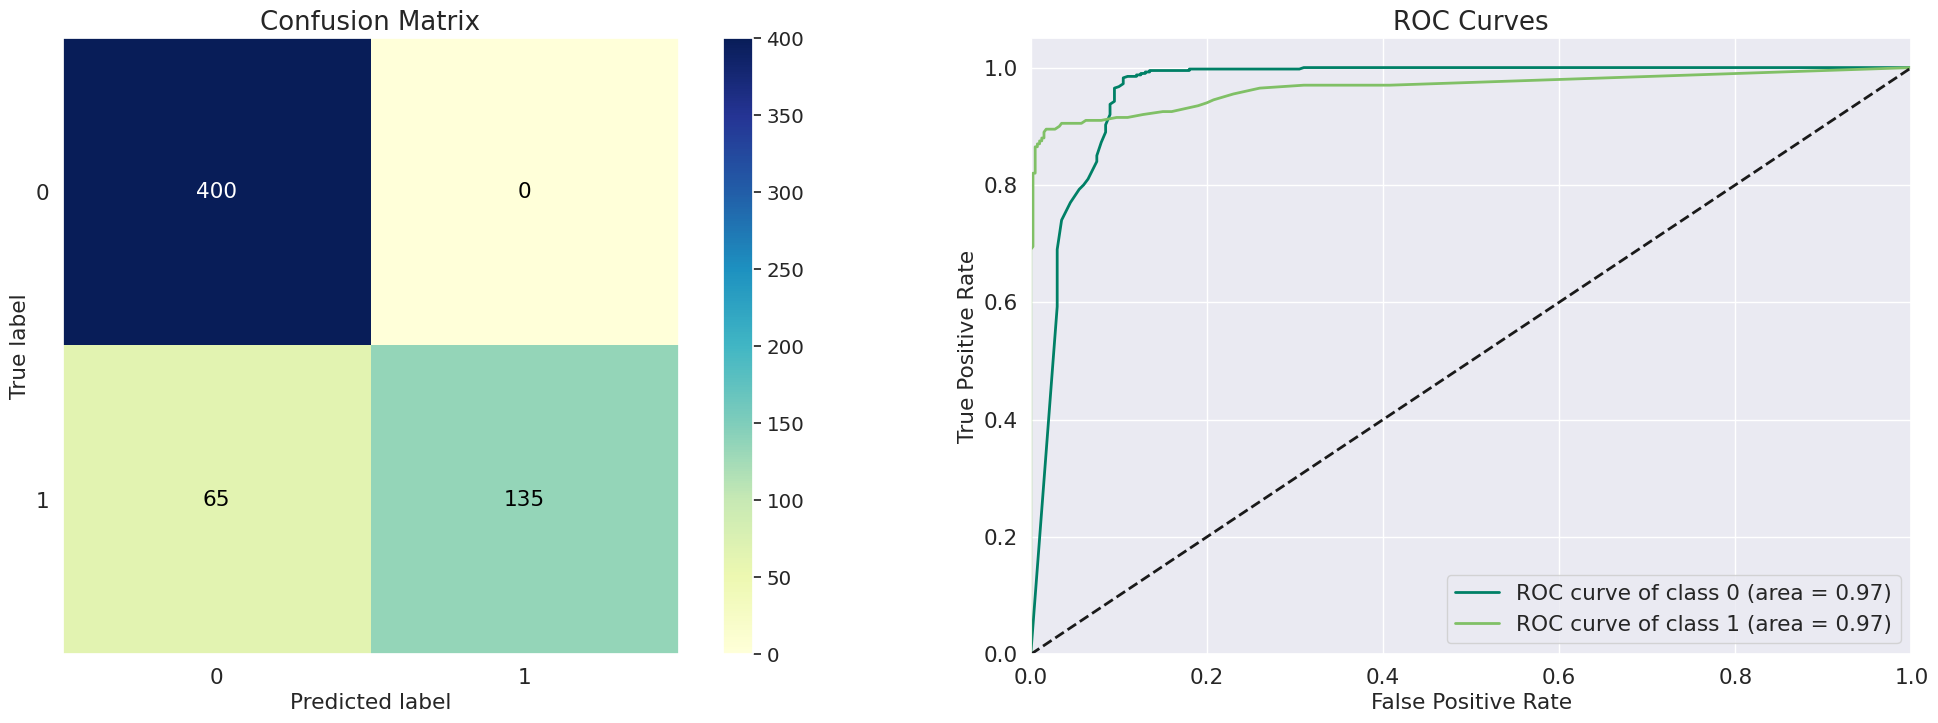

In [ ]:
#Load Randomforest classifier model from sklearn
#We will use GridSearchCV for finding the ideal set of hyper parameters for our hypertuning

from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier()
from sklearn.model_selection import GridSearchCV
# Define a grid of hyperparameters to search

param_grid = {
    'n_estimators': [100,200,200] # Number of trees in the forest
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

#Call the train fucntion to train the model and calculate the evaluation metrics
#Train fucntion will also plot the confusion matric and AUC/ROC curves
#Evaluate the model on the test set using the best parameters
train_model(best_model)

#### Our test dataset contains 600 datapoints. 400 are hams and 200 are spams.Random forest classifier model classifies ham messages without any error.In case of spam messages, it identified 135 spam messages correctly while it identified 65 spam messages incorrectly as ham. Both random forest and logistic regression models perform at the same level.

### XGBoost

Accuracy of the model: 0.902
Precision Score of the model: 0.986
Recall Score of the model: 0.715
F1 Score of the model: 0.829


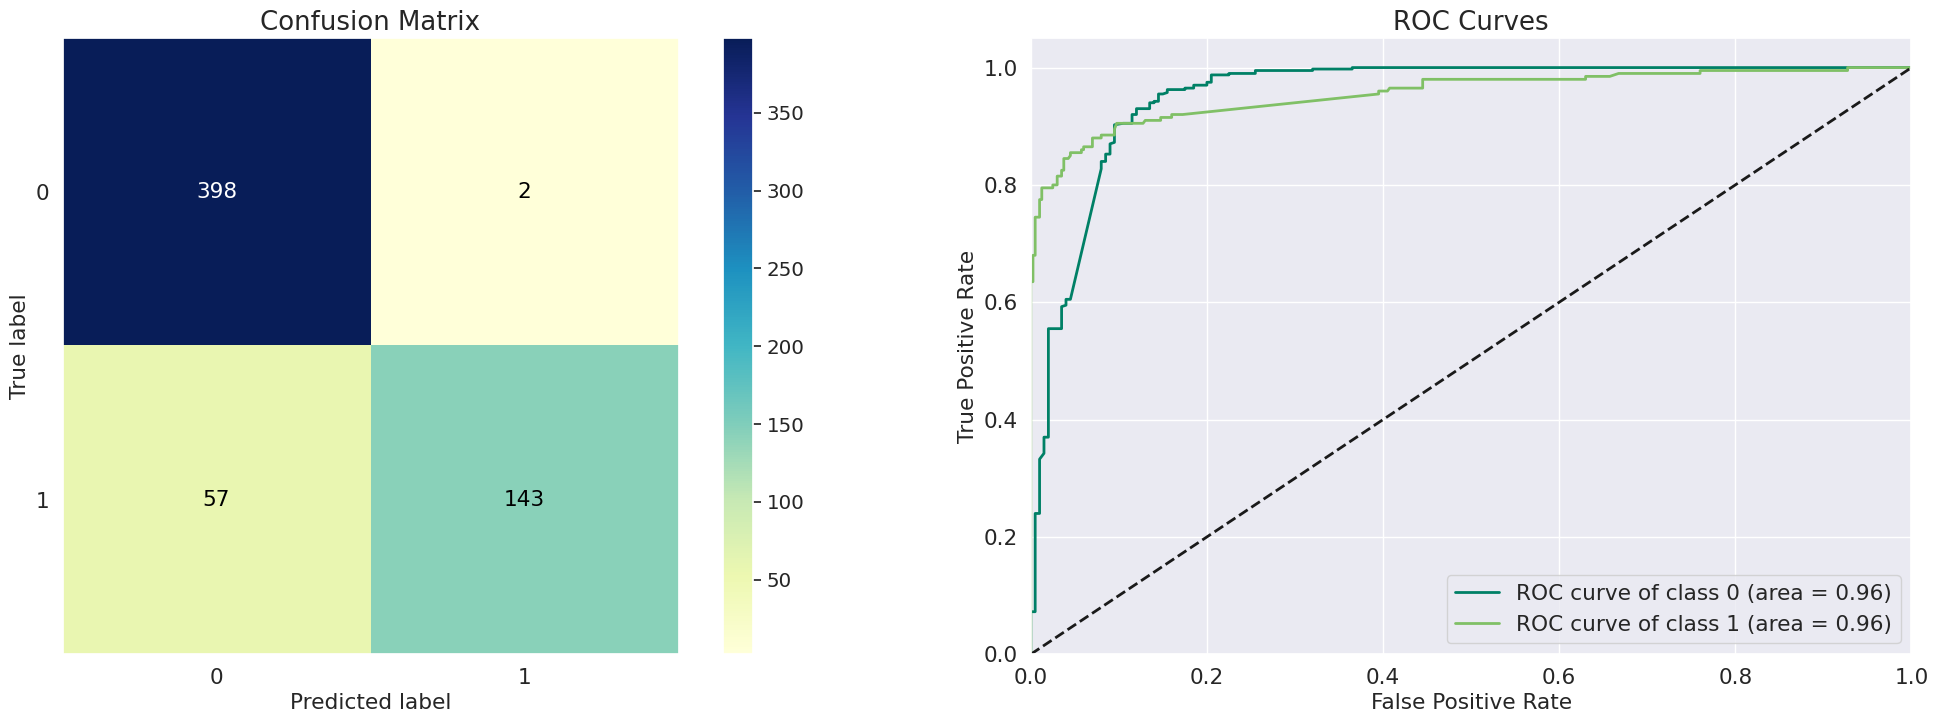

In [ ]:
from xgboost import XGBClassifier
# Create an XGBClassifier
xgb_classifier = XGBClassifier()

# Define a grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'n_estimators': [100, 200, 300],  # Number of trees (boosting rounds)
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_

#Call the train fucntion to train the model and calculate the evaluation metrics
#Train fucntion will also plot the confusion matric and AUC/ROC curves
#Evaluate the model on the test set using the best parameters
train_model(best_model)

####Our test dataset contains 600 datapoints. 400 are hams and 200 are spams.Random forest classifier model classifies ham messages almost without any error.In case of spam messages, it identified 135 spam messages correctly while it identified 57 spam messages incorrectly as ham. All three models  random forest, logistic regression, and XGBoost perform at the same level with logistic regression performing slightly better.

####Impact of Feature Scaling: Logistic Regression might be less sensitive to feature scaling issues than tree-based models like Random Forest or XGBoost. Imbalanced data can sometimes be affected by scaling discrepancies, and Logistic Regression might handle this more gracefully.

####Handling of Minority Class: Logistic Regression might be capturing patterns better within the minority class due to its optimization objective (maximizing likelihood). In some cases, tree-based models might not focus as strongly on the minority class if the sampling during tree construction isn't adjusted.

####Complexity of Decision Boundaries: Logistic Regression tends to produce linear decision boundaries, which could be more suitable if the data has separable classes with a more linear relationship between features and target.

####To overcome this challenge, let's combine classification power of all models and model a stacked classifier.



### Stacked Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
base_models = [
    ('logreg', LogisticRegression()),
    ('rf', RandomForestClassifier(n_estimators=300,random_state=42)),
    ('xgb',xgb.XGBClassifier(learning_rate=0.1,n_estimators=200, random_state=42))
]

# Initialize the StackingClassifier with a meta-model (here we use LogisticRegression)
stacked_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(),cv=5)

# Train the stacked model on the training data
stacked_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = stacked_model.predict(X_test)

Accuracy of the model: 0.932
Precision Score of the model: 0.994
Recall Score of the model: 0.8
F1 Score of the model: 0.886


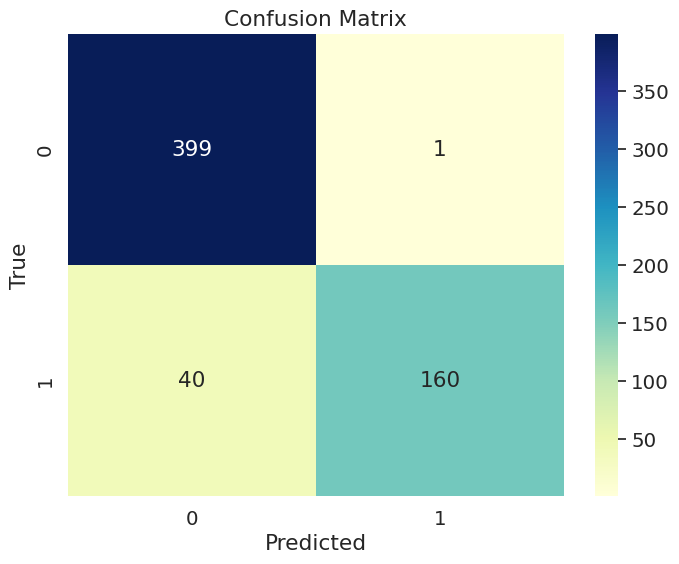

In [ ]:
from sklearn.metrics import confusion_matrix
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1score=round(f1_score(y_test,y_pred),3)
print(f'Accuracy of the model: {accuracy}')
print(f'Precision Score of the model: {precision}')
print(f'Recall Score of the model: {recall}')
print(f'F1 Score of the model: {f1score}')

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.set_context('notebook', font_scale=1.3)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


####As expected Stacked classifier performs better than all individual models.Our test dataset contains 600 datapoints. 400 are hams and 200 are spams.STacked classifier model classifies ham messages almost without any error.In case of spam messages, it identified 160 spam messages correctly while it identified 40 spam messages incorrectly as ham.

### RNN - LSTM

In [ ]:
#Install required libraries
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 847.3 kB/s eta 0:00:00


In [ ]:
#Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tensorflow import keras
from keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras.layers import Dense, BatchNormalization, Embedding, LSTM
from keras.metrics import Accuracy
from keras import utils
from keras import callbacks
from sklearn.model_selection import train_test_split
from absl import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
#For LSTM we use numerical encoding of words. The text is represented as a vector.
#We will train tokenizer for that
NUM_WORDS = 10000
MAX_TEXT_LEN = 100

X_train=train_dataset["message"]
y_train=train_dataset["flag"].values
X_test=test_dataset["message"]
y_test=test_dataset["flag"].values

tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

In [ ]:
# Standardization of the number of elements in a vector
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences_train, maxlen=MAX_TEXT_LEN)
X_test = pad_sequences(sequences_test, maxlen=MAX_TEXT_LEN)

In [ ]:
print(f'Training sample size: {len(X_train)}')
print(f'Test sample size: {len(X_test)}')

Training sample size: 4366
Test sample size: 600


In [ ]:
#Creating and training a reccurent model (LSTM)
# Initialising the RNN
model = Sequential()

# Add an Embedding layer with a specified vocabulary size (NUM_WORDS)
model.add(Embedding(NUM_WORDS, 64, input_length=MAX_TEXT_LEN))

# Add LSTM layers
model.add(LSTM(3, return_sequences=True))
model.add(LSTM(5, return_sequences=True))
model.add(BatchNormalization()) # Normalize the activations of the previous layer
model.add(LSTM(12))

# Add a Dense layer with a single output unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Define callbacks for training
callbacks = [
    callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=10, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, min_delta=0.01, min_lr=1e-10, patience=4, verbose=1, mode='auto')
]

In [ ]:
# Compile the model with metrics, loss function, and optimizer
model.compile(metrics=['Accuracy'], loss='binary_crossentropy', optimizer='Adam')

In [ ]:
# Train the model using training data, with batch size, epochs, validation split, and callbacks
history = model.fit(X_train, y_train, batch_size=50, epochs=10, validation_split=0.2,  callbacks=callbacks)


Epoch 1/10
70/70 [==============================] - 18s 177ms/step - loss: 0.2899 - Accuracy: 0.9802 - val_loss: 0.7147 - val_Accuracy: 0.7025 - lr: 0.0010
Epoch 2/10
70/70 [==============================] - 9s 126ms/step - loss: 0.0444 - Accuracy: 1.0000 - val_loss: 1.0860 - val_Accuracy: 0.7025 - lr: 0.0010
Epoch 3/10
70/70 [==============================] - 7s 102ms/step - loss: 0.0170 - Accuracy: 1.0000 - val_loss: 1.2716 - val_Accuracy: 0.7025 - lr: 0.0010
Epoch 4/10
70/70 [==============================] - 8s 113ms/step - loss: 0.0096 - Accuracy: 1.0000 - val_loss: 1.4114 - val_Accuracy: 0.7025 - lr: 0.0010
Epoch 5/10
70/70 [==============================] - 11s 161ms/step - loss: 0.0065 - Accuracy: 1.0000 - val_loss: 1.5169 - val_Accuracy: 0.7025 - lr: 0.0010
Epoch 6/10
70/70 [==============================] - 13s 191ms/step - loss: 0.0049 - Accuracy: 1.0000 - val_loss: 1.5993 - val_Accuracy: 0.7025 - lr: 0.0010
Epoch 7/10
70/70 [==============================] - 10s 145ms/step 

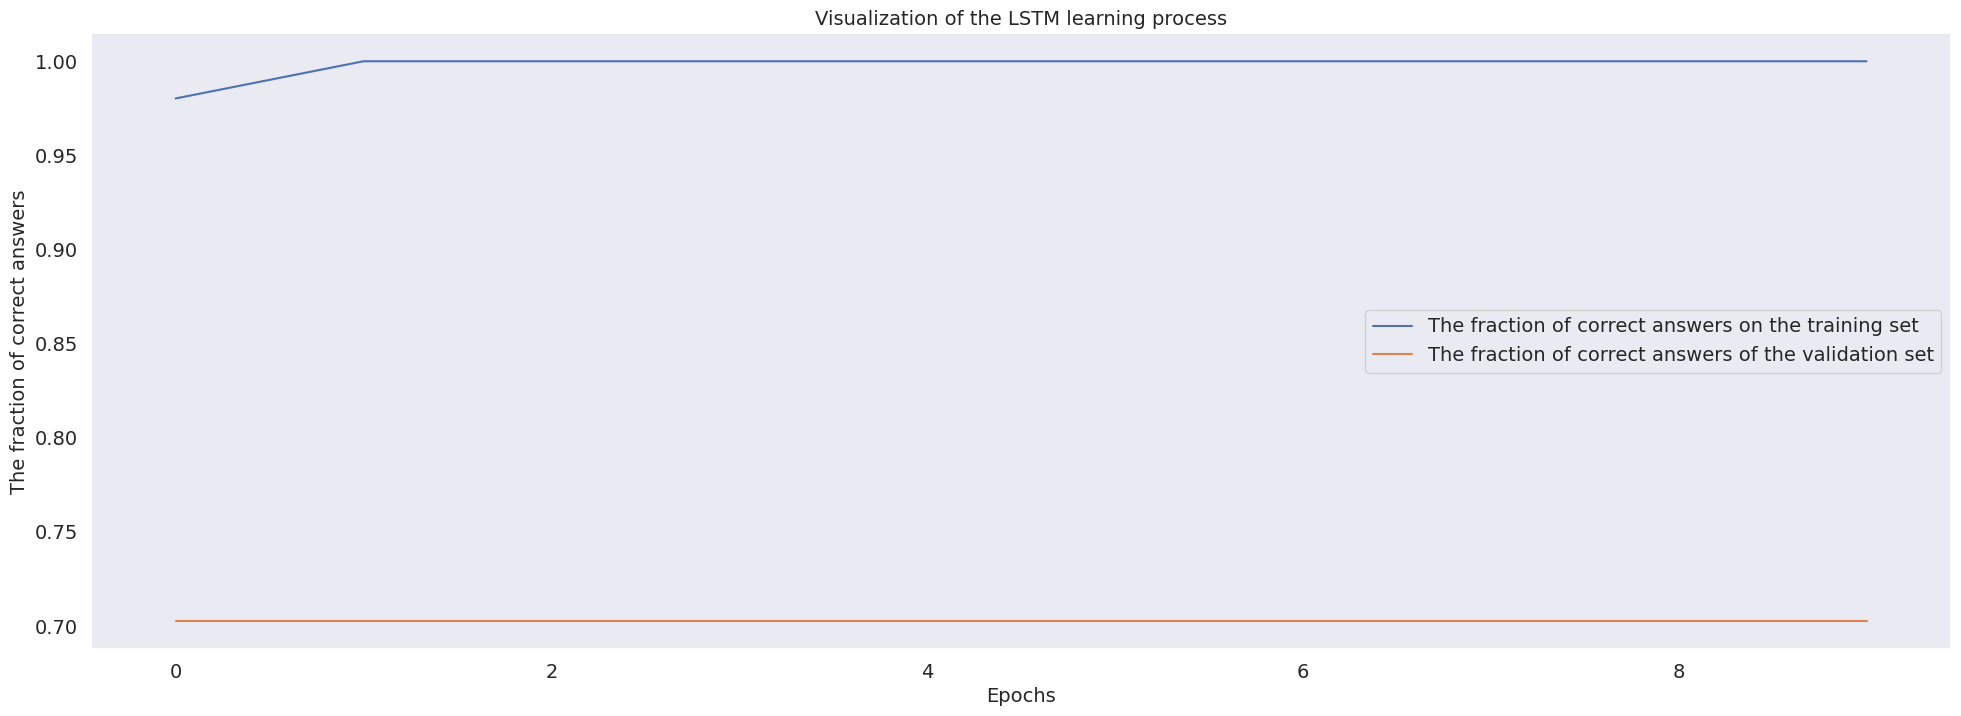

In [ ]:
#Visualize the training and validation accuracy during the LSTM model's learning process
plt.figure(figsize=(24, 8))
plt.title('Visualization of the LSTM learning process', fontsize=14)

# Plot the training accuracy
plt.plot(history.history['Accuracy'], label='The fraction of correct answers on the training set')

# Plot the validation accuracy
plt.plot(history.history['val_Accuracy'], label='The fraction of correct answers of the validation set')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('The fraction of correct answers', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.show()

In [ ]:
# Evaluate and print the model's metrics on the test dataset
print(f'Metric on test: {model.evaluate(X_test, y_test)}')

# Evaluate and print the model's metrics on the train dataset
print(f'Metric on train: {model.evaluate(X_train, y_train)}')

19/19 [==============================] - 0s 22ms/step - loss: 2.0022 - Accuracy: 0.6667
Metric on test: [2.002216100692749, 0.6666666865348816]
137/137 [==============================] - 3s 21ms/step - loss: 0.3597 - Accuracy: 0.9404
Metric on train: [0.3597433865070343, 0.9404489398002625]


In [ ]:
#Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           640000    
                                                                 
 lstm_6 (LSTM)               (None, 100, 3)            816       
                                                                 
 lstm_7 (LSTM)               (None, 100, 5)            180       
                                                                 
 batch_normalization_2 (Bat  (None, 100, 5)            20        
 chNormalization)                                                
                                                                 
 lstm_8 (LSTM)               (None, 12)                864       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                      

In [ ]:
# Get predicted probabilities from the model for the test data
y_prob = model.predict(X_test, verbose=0)

# Convert probabilities to binary classes based on a threshold
y_pred = np.argmax(y_prob, axis=1)

Accuracy of the model: 0.667
Precision Score of the model: 0.0
Recall Score of the model: 0.0
F1 Score of the model: 0.0


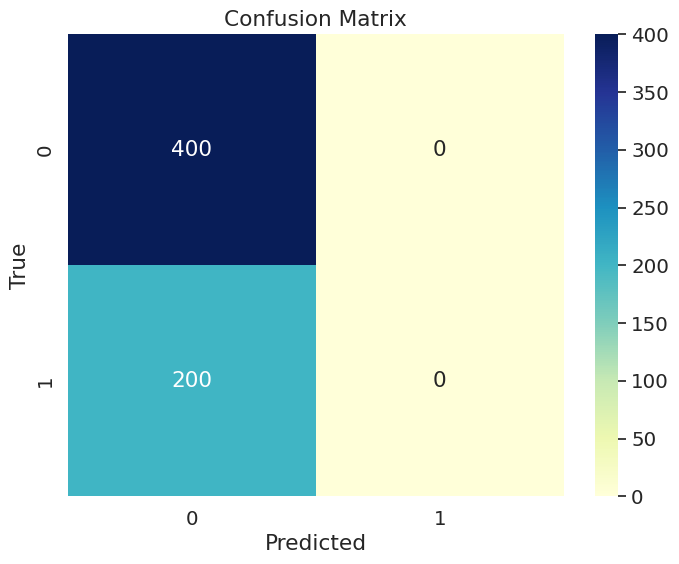

In [ ]:
from sklearn.metrics import confusion_matrix
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1score=round(f1_score(y_test,y_pred),3)

print(f'Accuracy of the model: {accuracy}')
print(f'Precision Score of the model: {precision}')
print(f'Recall Score of the model: {recall}')
print(f'F1 Score of the model: {f1score}')
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.set_context('notebook', font_scale=1.3)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### LSTM is performing very poorly. It is classifying majority class everytime.LSTM models might require specific handling of imbalanced data. Techniques like class weighting, oversampling, or using specialized loss functions can help LSTM focus on the minority class.